# Image Captioning with Attention
We will use an attention based model. It will allow us to see which parts of the model focuses on as it generates a caption. <br>
We will train a model on a relatively small amount of data. The model will be trained on the first 30,000 captions which corresponds to about ~20,000 images.

In [0]:
from __future__ import absolute_import, division, print_function

### Installing TensorFlow-GPU 2.0.0 Alpha

In [2]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

    100% |████████████████████████████████| 332.1MB 61kB/s 


### Importing the required libraries

In [0]:
import tensorflow as tf
tf.executing_eagerly()
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import re
import numpy as np
import os
import time 
import json
from glob import glob
from PIL import Image
import pickle

### Downloading & Preparing MS-COCO Dataset

In [0]:
annotation_zip = tf.keras.utils.get_file('captions.zip',
                                        cache_subdir=os.path.abspath('.'),
                                        origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                        extract = True)
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'

name_of_zip = 'train2014.zip'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
  image_zip = tf.keras.utils.get_file(name_of_zip,
                                     cache_subdir=os.path.abspath('.'),
                                     origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                     extract = True)
  PATH = os.path.dirname(image_zip)+'/train2014/'
else:
  PATH = os.path.abspath('.')+'/train2014/'

### Limiting training set size for faster training (Optional)

In [0]:
# read the json file
with open(annotation_file, 'r') as f:
  annotations = json.load(f)
  
# storing the captions and the images name in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
  caption = '<start>' + annot['caption'] + '<end>'
  image_id = annot['image_id']
  full_coco_image_path = PATH + 'COCO_train2014_'+'%012d.jpg' % (image_id)
  
  all_img_name_vector.append(full_coco_image_path)
  all_captions.append(caption)
  
# shuffling the captions and image_names together
# setting a random state
train_captions, img_name_vector = shuffle(all_captions,
                                         all_img_name_vector,
                                         random_state=1)

# selecting the first 30K captions from the shuffled set
num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [7]:
len(train_captions), len(all_captions)

(30000, 414113)

### Preprocessing Images using InceptionV3
We will now use InceptionV3 (pretrained on Imagenet) to classify each image. We will extract features from the lasst convolutional layer.

### Resizing images

In [0]:
def load_image(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299,299))
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

### Initializing InceptionV3 and loading pretrained Imagenet weights
We will build a model where the output layer is the last convolutional layer in the InceptionV3 architecture. Each image is forwarded through the network and the vector that we get at the end is stored in a dictionary (image_name --> feature_vector). We use the last convolutional layer because we are using attention in this example. The shape of the output of this layer is <code>8x8x2048</code>. We avoid doing this during training so it does not become a bottleneck. After all the images are passed through the network, we pickle the dictionary and save it to disk.

In [0]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                               weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

### Caching the features extracted from InceptionV3
We will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but memory intensive, requiring <code>8x8x2048</code> floats per image. At the time of writing, this would exceed the memory limitations of Colab (although these may change, an instance appears to have about 12GB of memory currently).
<br>
Performance could be improved with a more sophisticated caching strategy (e.g., by sharding the images to reduce random access disk I/O) at the cost of more code.

In [0]:
# getting the unique images
encode_train = sorted(set(img_name_vector))

# feel free to change the batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features, 
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

### Preprocessing & Tokenizing the Captions
<ul>
    <li> First, we'll tokenize the captions (e.g., by splitting on spaces). This will give us a vocabulary of all the unique words in the data (e.g., "surfing", "football", etc). 
    <li> Next, we'll limit the vocabulary size to the top 5,000 words to save memory. We'll replace all other words with the token "UNK" (for unknown).
    <li> Finally, we create a word --> index mapping and vice-versa.
    <li> We will then pad all sequences to the be same length as the longest one.

In [0]:
# Finding max length of any caption in the dataset
def calc_max_length(tensor):
  return max(len(t) for t in tensor)

In [0]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [0]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [0]:
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [0]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [0]:
max_length = calc_max_length(train_seqs)

### Split the data into training and testing sets

In [0]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                   cap_vector,
                                                                   test_size=0.2,
                                                                   random_state=0)

In [21]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

## Creating a Dataset for Training the model

### HyperParameters

In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
# From InceptionV3
features_shape = 2048
attention_features_shape = 64

In [0]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [24]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls = tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

W0401 20:54:28.791220 140557421598592 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/script_ops.py:476: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


## Building the Model
We extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape <code>(8,8,2048)</code>. We squash that to a shape of <code>(64,2048)</code>. This vector is then passed through the CNN Encoder which is consisted of a single Fully Connected Layer. The RNN (GRU) attendsd over the image to predict the next word.

In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
  
  def call(self, features, hidden):
    
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
    
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    
    return context_vector, attention_weights


In [0]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)
        
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


In [0]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)
    
    self.attention = BahdanauAttention(self.units)
        
  def call(self, x, features, hidden):
    
    context_vector, attention_weights = self.attention(features, hidden)
    
    x = self.embedding(x)
    
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    
    output, state = self.gru(x)
    
    x = self.fc1(output)
    
    x = tf.reshape(x, (-1, x.shape[2]))
    
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


In [0]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)


### Checkpoint

In [0]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder, 
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [0]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

## Training
<ul>
    <li> We extract the features stored in the respective <code>.npy</code> files and then pass those features through the encoder.
    <li> The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
    <li> The decoder returns the predictions and the decoder hidden state.
    <li> The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
    <li> Use teacher forcing to decide the next input to the decoder.
    <li> Teacher forcing is the technique where the target word is passed as the next input to the decoder.
    <li> The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [0]:
loss_plot = []

In [0]:
@tf.function
def train_step(img_tensor, target):
  loss = 0
        
  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
  
  with tf.GradientTape() as tape:
      features = encoder(img_tensor)
      
      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)
          
          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)
  
  total_loss = (loss / int(target.shape[1]))
  
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  
  gradients = tape.gradient(loss, trainable_variables) 
  
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [34]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        
        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()
    
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1, 
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 2.0385
Epoch 1 Batch 100 Loss 1.0510
Epoch 1 Batch 200 Loss 0.9041
Epoch 1 Batch 300 Loss 0.9340
Epoch 1 Loss 0.956985
Time taken for 1 epoch 272.5595462322235 sec

Epoch 2 Batch 0 Loss 0.7695
Epoch 2 Batch 100 Loss 0.7544
Epoch 2 Batch 200 Loss 0.7094
Epoch 2 Batch 300 Loss 0.7964
Epoch 2 Loss 0.720795
Time taken for 1 epoch 192.7629792690277 sec

Epoch 3 Batch 0 Loss 0.6722
Epoch 3 Batch 100 Loss 0.6717
Epoch 3 Batch 200 Loss 0.6466
Epoch 3 Batch 300 Loss 0.7351
Epoch 3 Loss 0.652174
Time taken for 1 epoch 192.2872130870819 sec

Epoch 4 Batch 0 Loss 0.6212
Epoch 4 Batch 100 Loss 0.6251
Epoch 4 Batch 200 Loss 0.6111
Epoch 4 Batch 300 Loss 0.6922
Epoch 4 Loss 0.611702
Time taken for 1 epoch 192.6782145500183 sec

Epoch 5 Batch 0 Loss 0.5777
Epoch 5 Batch 100 Loss 0.5868
Epoch 5 Batch 200 Loss 0.5775
Epoch 5 Batch 300 Loss 0.6569
Epoch 5 Loss 0.581102
Time taken for 1 epoch 192.84017157554626 sec

Epoch 6 Batch 0 Loss 0.5467
Epoch 6 Batch 100 Loss 0.5696
Epoch 6 Bat

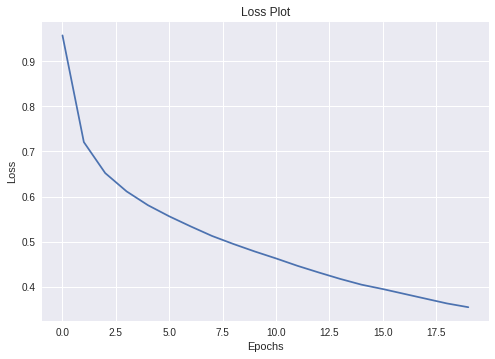

In [35]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption
<ul>
    <li> The evaluate function is similar to the training loop, except we don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
        <li> Stop predicting when the model predicts the end token.
            <li> And store the attention weights for every time step.

In [0]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot


In [0]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))
    
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


Real Caption: <start>some people are walking on the sidewalk by a traffic light <end>
Prediction Caption: woman with a bench crossing the street <end>


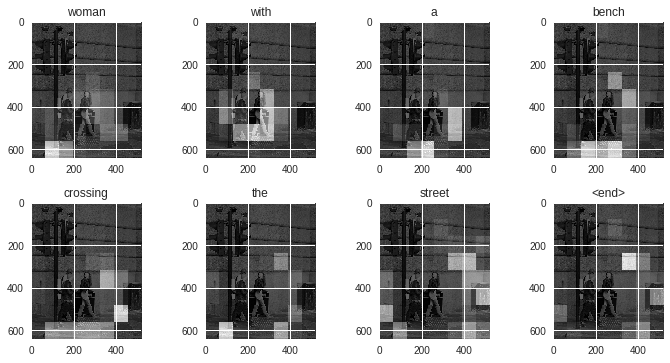

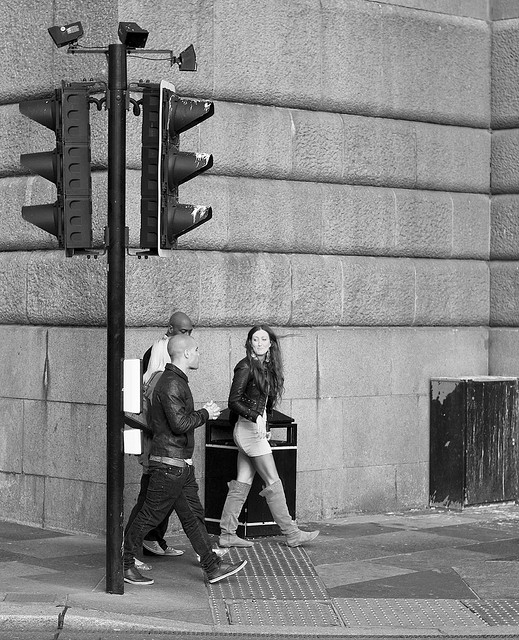

In [40]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# opening the image
Image.open(img_name_val[rid])


65536/64400 [==============================] - 0s 0us/step
Prediction Caption: man is riding a surfboard riding a surfboard in the ocean <end>


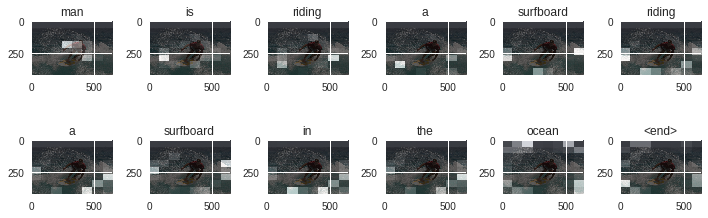

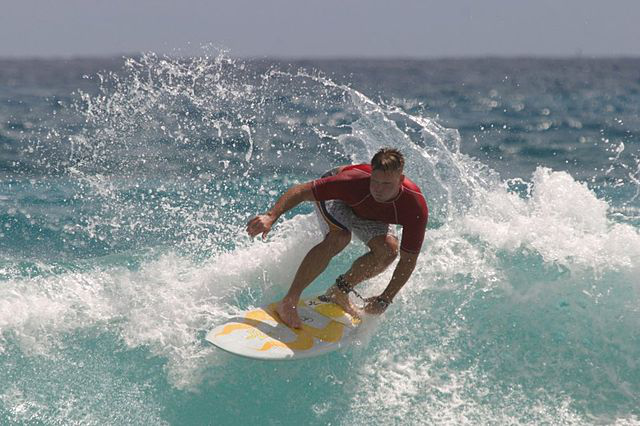

In [39]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, 
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)